In [3]:
# Cell 1: Import necessary libraries
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import numpy as np
import random
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import root_mean_squared_error
import time  # Import time module for measuring execution time


In [4]:
# Cell 2: Define the function to create the data model
def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data["distance_matrix"] = [ # actually a time matrix just naming it distance_matrix 
        [0, 6, 9, 8, 7, 3, 6, 2, 3, 2, 6, 6, 4, 4, 5, 9, 7],
        [6, 0, 8, 3, 2, 6, 8, 4, 8, 8, 13, 7, 5, 8, 12, 10, 14],
        [9, 8, 0, 11, 10, 6, 3, 9, 5, 8, 4, 15, 14, 13, 9, 18, 9],
        [8, 3, 11, 0, 1, 7, 10, 6, 10, 10, 14, 6, 7, 9, 14, 6, 16],
        [7, 2, 10, 1, 0, 6, 9, 4, 8, 9, 13, 4, 6, 8, 12, 8, 14],
        [3, 6, 6, 7, 6, 0, 2, 3, 2, 2, 7, 9, 7, 7, 6, 12, 8],
        [6, 8, 3, 10, 9, 2, 0, 6, 2, 5, 4, 12, 10, 10, 6, 15, 5],
        [2, 4, 9, 6, 4, 3, 6, 0, 4, 4, 8, 5, 4, 3, 7, 8, 10],
        [3, 8, 5, 10, 8, 2, 2, 4, 0, 3, 4, 9, 8, 7, 3, 13, 6],
        [2, 8, 8, 10, 9, 2, 5, 4, 3, 0, 4, 6, 5, 4, 3, 9, 5],
        [6, 13, 4, 14, 13, 7, 4, 8, 4, 4, 0, 10, 9, 8, 4, 13, 4],
        [6, 7, 15, 6, 4, 9, 12, 5, 9, 6, 10, 0, 1, 3, 7, 3, 10],
        [4, 5, 14, 7, 6, 7, 10, 4, 8, 5, 9, 1, 0, 2, 6, 4, 8],
        [4, 8, 13, 9, 8, 7, 10, 3, 7, 4, 8, 3, 2, 0, 4, 5, 6],
        [5, 12, 9, 14, 12, 6, 6, 7, 3, 3, 4, 7, 6, 4, 0, 9, 2],
        [9, 10, 18, 6, 8, 12, 15, 8, 13, 9, 13, 3, 4, 5, 9, 0, 9],
        [7, 14, 9, 16, 14, 8, 5, 10, 6, 5, 4, 10, 8, 6, 2, 9, 0],
    ]
    data["time_windows"] = [
        (0, 5),  # depot
        (7, 12),  # 1
        (10, 15),  # 2
        (16, 18),  # 3
        (10, 13),  # 4
        (0, 5),  # 5
        (5, 10),  # 6
        (0, 4),  # 7
        (5, 10),  # 8
        (0, 3),  # 9
        (10, 16),  # 10
        (10, 15),  # 11
        (0, 5),  # 12
        (5, 10),  # 13
        (7, 8),  # 14
        (10, 15),  # 15
        (11, 15),  # 16
    ]
    data["num_vehicles"] = 4
    data["depot"] = 0
    return data

# Cell 3: Define constants and initialize the problem data
# Define constants
ALPHA = 1.0
BETA = 2.0
RHO = 0.1
Q = 100
NUM_ANTS = 10
MAX_ITER = 1000
TIME_WINDOW_PENALTY = 10
CAPACITY_PENALTY = 100

# Define the problem data
data = create_data_model()
distance_matrix = np.array(data["distance_matrix"])
num_nodes = len(distance_matrix)
time_windows = data["time_windows"]
demands = [0] * num_nodes
vehicle_capacity = 20
num_vehicles = data["num_vehicles"]


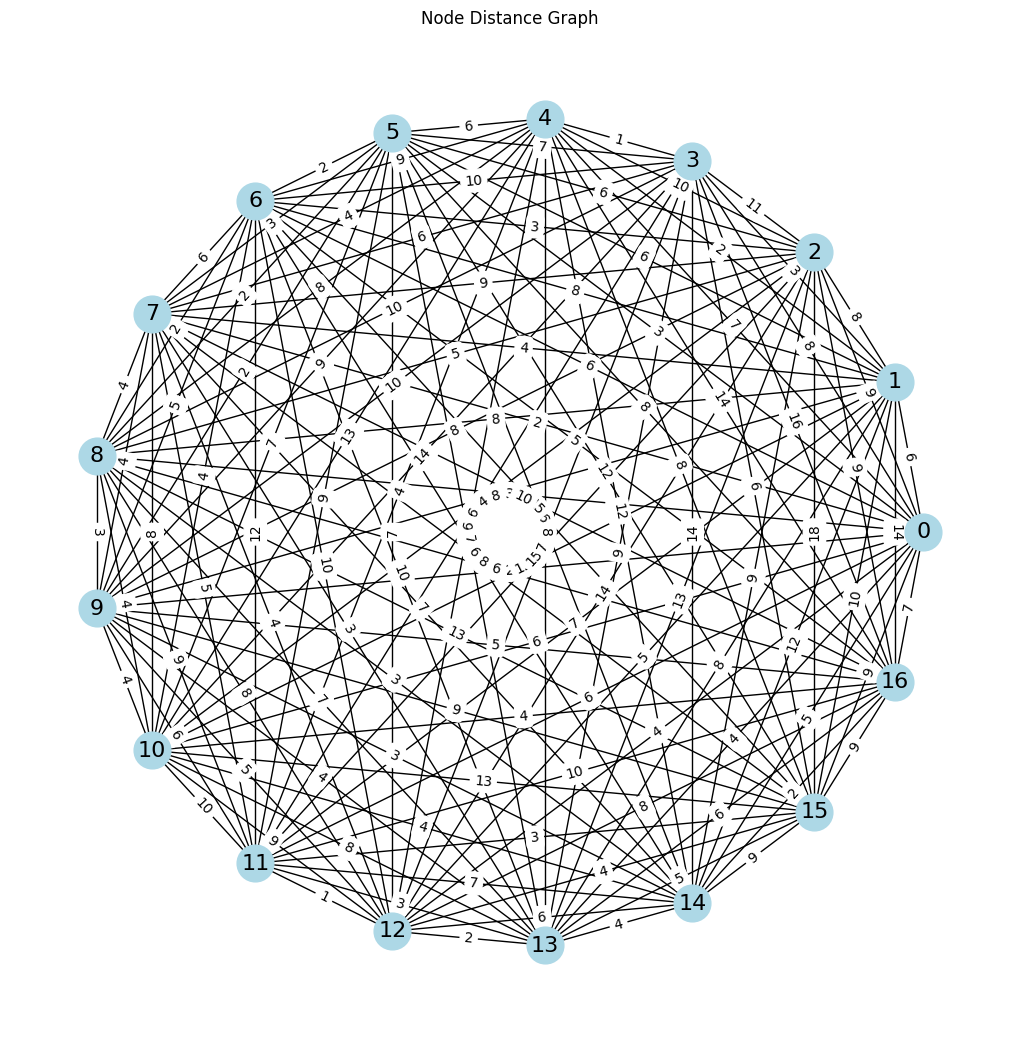

In [11]:
# Cell 13: Visualize the nodes and distances
import networkx as nx
import matplotlib.pyplot as plt

def visualize_graph(distance_matrix):
    G = nx.Graph()  # Create a graph object

    num_nodes = len(distance_matrix)
    pos = {}  # Position dictionary for nodes

    # Add nodes and edges to the graph
    for i in range(num_nodes):
        G.add_node(i)
        pos[i] = (np.cos(2 * np.pi * i / num_nodes), np.sin(2 * np.pi * i / num_nodes))  # Circular layout

    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                G.add_edge(i, j, weight=distance_matrix[i][j])

    # Draw the graph
    plt.figure(figsize=(10, 10))
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=700, font_size=16)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title("Node Distance Graph")
    plt.axis('equal')
    plt.show()

# Call the visualization function
visualize_graph(data["distance_matrix"])


In [5]:
# Cell 4: Generate training data for the ML model
X_train = []
y_train = []

for i in range(num_nodes):
    for j in range(num_nodes):
        if i != j:
            dij = distance_matrix[i][j]
            delta_t = max(0, time_windows[j][1] - time_windows[i][0])
            qj = demands[j]
            heuristic = 1 / dij * (1 + delta_t / 10) * (1 - qj / vehicle_capacity)
            X_train.append([dij, delta_t, qj])
            y_train.append(heuristic)


In [6]:
# Cell 5: Train a decision tree regressor
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

# Predict heuristic values for the training set
y_pred = model.predict(X_train)

# Calculate and print the Mean Squared Error (MSE) for the training data
mse = root_mean_squared_error(y_train, y_pred)
print(f"Mean Squared Error (MSE) on Training Data: {mse:.4f}")


Mean Squared Error (MSE) on Training Data: 0.0000


In [9]:
# Cell 6: Define pheromone level initialization
def initialize_pheromone_levels(n, tau0):
    return np.ones((n, n)) * tau0

# Cell 7: Define heuristic value calculation
def heuristic_value(i, j):
    dij = distance_matrix[i][j]
    delta_t = max(0, time_windows[j][1] - time_windows[i][0])
    qj = demands[j]
    return model.predict([[dij, delta_t, qj]])[0]


# Cell 8: Construct a solution
def construct_solution(graph, pheromone, alpha, beta, num_ants):
    solutions = []
    for _ in range(num_ants):
        solution = []
        visited = set()
        current_node = 0
        visited.add(current_node)
        route = [current_node]
        while len(visited) < len(graph):
            feasible_nodes = [j for j in range(len(graph)) if j not in visited]
            if not feasible_nodes:
                break
            probabilities = [pheromone[current_node][j]**alpha * heuristic_value(current_node, j)**beta for j in feasible_nodes]
            total_prob = sum(probabilities)
            if total_prob == 0:
                probabilities = [1.0 / len(feasible_nodes)] * len(feasible_nodes)
            else:
                probabilities = [p / total_prob for p in probabilities]
            next_node = np.random.choice(feasible_nodes, p=probabilities)
            route.append(next_node)
            visited.add(next_node)
            current_node = next_node
        route.append(0)  # Return to depot
        solutions.append(route)
    return solutions

# Cell 9: Define functions for calculating tour length and penalties
def calculate_tour_length(tour):
    length = 0
    for i in range(len(tour) - 1):
        length += distance_matrix[tour[i]][tour[i + 1]]
    return length

# Apply time window penalty
def apply_time_window_penalty(route):
    penalty = 0
    current_time = 0
    for i in range(len(route) - 1):
        arrival_time = current_time + distance_matrix[route[i]][route[i + 1]]
        if arrival_time < time_windows[route[i + 1]][0]:
            current_time = time_windows[route[i + 1]][0]
        elif arrival_time > time_windows[route[i + 1]][1]:
            penalty += TIME_WINDOW_PENALTY
        current_time += distance_matrix[route[i]][route[i + 1]]
    return penalty

# Apply capacity constraints
def apply_capacity_constraints(route):
    current_demand = 0
    feasible = True
    for node in route:
        current_demand += demands[node]
        if current_demand > vehicle_capacity:
            feasible = False
            break
    return feasible

# Cell 10: Define pheromone update functions
# Local pheromone update
def local_pheromone_update(pheromone, solutions, rho, Q):
    for solution in solutions:
        tour_length = calculate_tour_length(solution)
        for i in range(len(solution) - 1):
            pheromone[solution[i]][solution[i + 1]] += Q / tour_length
            pheromone[solution[i + 1]][solution[i]] += Q / tour_length
    pheromone *= (1 - rho)
    return pheromone

# Global pheromone update
def global_pheromone_update(pheromone, best_solution, rho, Q):
    best_length = calculate_tour_length(best_solution)
    for i in range(len(best_solution) - 1):
        pheromone[best_solution[i]][best_solution[i + 1]] += Q / best_length
        pheromone[best_solution[i + 1]][best_solution[i]] += Q / best_length
    pheromone *= (1 - rho)
    return pheromone


# Cell 11: Define the Ant Colony Optimization algorithm
def ant_colony_optimization(data):
    num_nodes = len(data["distance_matrix"])
    pheromone = initialize_pheromone_levels(num_nodes, 1.0)
    best_solution = None
    best_length = float("inf")
    
    start_time = time.time()  # Start time measurement
    
    for iteration in range(MAX_ITER):
        solutions = construct_solution(data["distance_matrix"], pheromone, ALPHA, BETA, NUM_ANTS)
        for solution in solutions:
            length = calculate_tour_length(solution) + apply_time_window_penalty(solution)
            if apply_capacity_constraints(solution):
                if length < best_length:
                    best_length = length
                    best_solution = solution
        
        pheromone = local_pheromone_update(pheromone, solutions, RHO, Q)
        if best_solution:
            pheromone = global_pheromone_update(pheromone, best_solution, RHO, Q)
    
    end_time = time.time()  # End time measurement
    total_time = end_time - start_time  # Calculate total running time
    
    return best_solution, best_length, total_time


In [10]:
# Cell 12: Run the Ant Colony Optimization and print results
if __name__ == "__main__":
    best_solution, best_length, total_time = ant_colony_optimization(data)
    print("Best Solution:", best_solution)
    print("Best Length:", best_length)
    print(f"Total Running Time: {total_time:.2f} seconds")


Best Solution: [0, 9, 5, 8, 6, 2, 10, 16, 14, 13, 12, 11, 15, 3, 4, 1, 7, 0]
Best Length: 156
Total Running Time: 243.92 seconds
